In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# 운영 체제 정보를 확인하고, matplotlib을 사용하여 그래프 그릴 준비하기
import platform
import matplotlib.pyplot as plt

%matplotlib inline

path = "c:/Windows/Fonts/malgun.ttf"

from matplotlib import font_manager, rc
if platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Sorry')

plt.rcParams['axes.unicode_minus'] = False

In [2]:
import tensorflow as tf
with tf.device('/GPU:0'):
  a = tf.constant([[1.0, 2.0], [4.0, 5.0]])

In [3]:
print("TensorFlow version:", tf.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

TensorFlow version: 2.6.0
GPU is available


In [12]:
shakespeare_url = 'http://homl.info/shakespeare'
filepath = tf.keras.utils.get_file('shakespeare.txt', shakespeare_url)
with open(filepath) as f:
    shakespeare_text = f.read()

# 파일이 잘 다운로드 됐는지 확인
print(shakespeare_text[:80])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.


In [13]:
# 사용자 정의 분할 함수 정의
def character_split(string):
    return tf.strings.unicode_split(string, 'UTF-8')

# 사용자 정의 분할 함수 사용
text_vec_layer = tf.keras.layers.TextVectorization(
    split=character_split, 
    standardize='lower_and_strip_punctuation'
)

text_vec_layer.adapt([shakespeare_text])
encoded = text_vec_layer([shakespeare_text])[0]

encoded -= 2  # 토큰 0(패딩 토큰)과 1(알려지지 않은 문자)을 사용하지 않으므로 무시

n_tokens = text_vec_layer.vocabulary_size() - 2
dataset_size = len(encoded)

print(n_tokens)
print(dataset_size)

29
1060997


In [14]:
def to_dataset(sequence, length, shuffle=False, seed=None, batch_size=32):
    ds = tf.data.Dataset.from_tensor_slices(sequence)
    ds = ds.window(length + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda window_ds: window_ds.batch(length + 1))
    if shuffle:
        ds = ds.shuffle(buffer_size=100_000, seed=seed)
    ds = ds.batch(batch_size)
    return ds.map(lambda window : (window[:, :-1], window[:, 1:])).prefetch(1)

In [15]:
length = 100
tf.random.set_seed(42)
train_set = to_dataset(encoded[:1_000_000], length=length, shuffle=True, seed=42)
valid_set = to_dataset(encoded[1_000_000:1_600_000], length=length)
test_set = to_dataset(encoded[1_600_000:], length=length)

In [16]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=n_tokens, output_dim=16),
    tf.keras.layers.GRU(128, return_sequences=True),
    tf.keras.layers.Dense(n_tokens, activation='softmax')
])
model.compile(loss='sparse_categorical_crossentropy', optimizer='nadam',
              metrics=['accuracy'])
model_ckpt = tf.keras.callbacks.ModelCheckpoint(
    'my_shakespeare_model.keras', monitor='val_accuracy', save_best_only=True)
history = model.fit(train_set, validation_data=valid_set, epochs=10,
                    callbacks=[model_ckpt])

Epoch 1/10
31247/31247 [==============================] - 530s 16ms/step - loss: 1.3630 - accuracy: 0.5736 - val_loss: 1.6810 - val_accuracy: 0.5120
Epoch 2/10
31247/31247 [==============================] - 544s 17ms/step - loss: 1.2699 - accuracy: 0.5970 - val_loss: 1.6657 - val_accuracy: 0.5181
Epoch 3/10
31247/31247 [==============================] - 501s 16ms/step - loss: 1.2548 - accuracy: 0.6005 - val_loss: 1.6618 - val_accuracy: 0.5194
Epoch 4/10
31247/31247 [==============================] - 517s 16ms/step - loss: 1.2471 - accuracy: 0.6022 - val_loss: 1.6802 - val_accuracy: 0.5188
Epoch 5/10
31247/31247 [==============================] - 546s 17ms/step - loss: 1.2417 - accuracy: 0.6035 - val_loss: 1.6593 - val_accuracy: 0.5178
Epoch 6/10
31247/31247 [==============================] - 520s 16ms/step - loss: 1.2376 - accuracy: 0.6046 - val_loss: 1.6864 - val_accuracy: 0.5188
Epoch 7/10
31247/31247 [==============================] - 529s 16ms/step - loss: 1.2350 - accuracy: 0.6051

In [17]:
shakespeare_model = tf.keras.Sequential([
    text_vec_layer,
    tf.keras.layers.Lambda(lambda X: X - 2), # <PAD>와 <UNK' 토큰 제외
    model
])

In [29]:
# 사전 훈련된 모델 다운로드 (GPU 사용 시스킵)
import tarfile
from pathlib import Path

# 파일 경로 설정
tgz_file_path = Path(r"C:\Users\niceq\Documents\DataScience\Hands_ML\Data\15. shakespeare_model.tgz")

# 압축 해제 디렉토리 설정
extract_dir = tgz_file_path.parent / "shakespeare_model"

# .tgz 파일 압축 해제
with tarfile.open(tgz_file_path, "r:gz") as tar:
    tar.extractall(path=extract_dir)
    print(f"Extracted to: {extract_dir}")

# 압축 해제된 파일 목록 확인
extracted_files = list(extract_dir.glob("**/*"))
print("Extracted files:")
for file in extracted_files:
    print(file)

Extracted to: C:\Users\niceq\Documents\DataScience\Hands_ML\Data\shakespeare_model
Extracted files:
C:\Users\niceq\Documents\DataScience\Hands_ML\Data\shakespeare_model\shakespeare_model
C:\Users\niceq\Documents\DataScience\Hands_ML\Data\shakespeare_model\shakespeare_model\assets
C:\Users\niceq\Documents\DataScience\Hands_ML\Data\shakespeare_model\shakespeare_model\keras_metadata.pb
C:\Users\niceq\Documents\DataScience\Hands_ML\Data\shakespeare_model\shakespeare_model\saved_model.pb
C:\Users\niceq\Documents\DataScience\Hands_ML\Data\shakespeare_model\shakespeare_model\variables
C:\Users\niceq\Documents\DataScience\Hands_ML\Data\shakespeare_model\shakespeare_model\variables\variables.data-00000-of-00001
C:\Users\niceq\Documents\DataScience\Hands_ML\Data\shakespeare_model\shakespeare_model\variables\variables.index


In [33]:
# GPU 사용 시 스킵
from keras.layers import Input

# 정확한 압축 해제된 SavedModel 경로를 설정
saved_model_path = extract_dir / "shakespeare_model" / "saved_model"

# 올바른 경로에 모델 파일이 있는지 확인
if not (saved_model_path / "saved_model.pb").exists():
    raise OSError(f"SavedModel file does not exist at: {saved_model_path}")

# TensorFlow SavedModel을 TFSMLayer로 불러오기
tfsmlayer = tf.keras.layers.TFSMLayer(str(saved_model_path), call_endpoint='serving_default')

# Keras 모델로 감싸기
inputs = Input(shape=(None,), dtype=tf.int32)  # 입력의 형태를 실제에 맞게 수정 필요
outputs = tfsmlayer(inputs)
wrapped_model = tf.keras.Model(inputs, outputs)

# 모델 요약 출력
wrapped_model.summary()

OSError: SavedModel file does not exist at: C:\Users\niceq\Documents\DataScience\Hands_ML\Data\shakespeare_model\shakespeare_model\saved_model

In [18]:
y_proba = shakespeare_model.predict(['To be or not to b'])[0, -1]
y_pred = tf.argmax(y_proba)
text_vec_layer.get_vocabulary()[y_pred+2]

'e'

In [19]:
log_probas = tf.math.log([[0.5, 0.4, 0.1]]) # 확률: 50%, 40%, 10%
tf.random.set_seed(42)
tf.random.categorical(log_probas, num_samples=8) # 8개의 샘플 출력

<tf.Tensor: shape=(1, 8), dtype=int64, numpy=array([[0, 0, 1, 1, 1, 0, 0, 0]], dtype=int64)>

In [27]:
def next_char(text, temperature=1):
    y_proba = shakespeare_model.predict([text])[0, -1:]
    rescaled_logits = tf.math.log(y_proba) / temperature
    char_id = tf.random.categorical(rescaled_logits, num_samples=1)[0, 0]
    return text_vec_layer.get_vocabulary()[char_id + 2]

In [24]:
def extend_text(text, n_chars=50, temperature=1):
    for _ in range(n_chars):
        text += next_char(text, temperature)
    return text

In [32]:
tf.random.set_seed(42)
print('온도:0.01:', extend_text("To be or not to be", temperature=0.01))
print('온도:1:', extend_text("To be or not to be", temperature=1))
print('온도:100:', extend_text("To be or not to be", temperature=100))

온도:0.01: To be or not to be so

petruchio
i will not be made a little shall b
온도:1: To be or not to be you prodowial it for the hour

tranio
asidd her l
온도:100: To be or not to bekeqipmeq lq
xre3ibmvc vrfllpzqa3btdy
ixurulzlyfeeu


In [44]:
def to_dataset_for_stateful_rnn(sequence, length):
    ds = tf.data.Dataset.from_tensor_slices(sequence)
    ds = ds.window(length + 1, shift=length, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(length + 1)).batch(1)
    return ds.map(lambda window: (window[:, :-1], window[:, 1:])).prefetch(1)

stateful_train_set = to_dataset_for_stateful_rnn(encoded[:1_000_000], length)
stateful_valid_set = to_dataset_for_stateful_rnn(encoded[1_000_000:1_060_000],length)
stateful_test_set = to_dataset_for_stateful_rnn(encoded[1_060_000:], length)

In [38]:
tf.random.set_seed(42)
Layers = tf.keras.layers

model = tf.keras.Sequential([
    Layers.Embedding(input_dim=n_tokens, output_dim=16,
                     batch_input_shape=[1, None]),
    Layers.GRU(128, return_sequences=True, stateful=True),
    Layers.Dense(n_tokens, activation='softmax')
])

In [39]:
class ResetStatesCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

In [40]:
model_ckpt = tf.keras.callbacks.ModelCheckpoint(
    "my_stateful_shakespeare_model",
    monitor="val_accuracy",
    save_best_only=True)

In [45]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
history = model.fit(stateful_train_set, validation_data=stateful_valid_set,
                    epochs=10, callbacks=[ResetStatesCallback(), model_ckpt])

Epoch 1/10
9999/9999 [==============================] - 154s 15ms/step - loss: 1.8283 - accuracy: 0.4484 - val_loss: 1.7134 - val_accuracy: 0.4737


INFO:tensorflow:Assets written to: my_stateful_shakespeare_model\assets


INFO:tensorflow:Assets written to: my_stateful_shakespeare_model\assets


Epoch 2/10
9999/9999 [==============================] - 153s 15ms/step - loss: 1.5368 - accuracy: 0.5267 - val_loss: 1.6399 - val_accuracy: 0.4953


INFO:tensorflow:Assets written to: my_stateful_shakespeare_model\assets


INFO:tensorflow:Assets written to: my_stateful_shakespeare_model\assets


Epoch 3/10
9999/9999 [==============================] - 155s 15ms/step - loss: 1.4598 - accuracy: 0.5482 - val_loss: 1.6115 - val_accuracy: 0.5096


INFO:tensorflow:Assets written to: my_stateful_shakespeare_model\assets


INFO:tensorflow:Assets written to: my_stateful_shakespeare_model\assets


Epoch 4/10
9999/9999 [==============================] - 150s 15ms/step - loss: 1.4215 - accuracy: 0.5589 - val_loss: 1.5948 - val_accuracy: 0.5185


INFO:tensorflow:Assets written to: my_stateful_shakespeare_model\assets


INFO:tensorflow:Assets written to: my_stateful_shakespeare_model\assets


Epoch 5/10
9999/9999 [==============================] - 158s 16ms/step - loss: 1.3983 - accuracy: 0.5649 - val_loss: 1.5864 - val_accuracy: 0.5217


INFO:tensorflow:Assets written to: my_stateful_shakespeare_model\assets


INFO:tensorflow:Assets written to: my_stateful_shakespeare_model\assets


Epoch 6/10
9999/9999 [==============================] - 170s 17ms/step - loss: 1.3827 - accuracy: 0.5688 - val_loss: 1.5878 - val_accuracy: 0.5221


INFO:tensorflow:Assets written to: my_stateful_shakespeare_model\assets


INFO:tensorflow:Assets written to: my_stateful_shakespeare_model\assets


Epoch 7/10
9999/9999 [==============================] - 178s 18ms/step - loss: 1.3712 - accuracy: 0.5717 - val_loss: 1.5832 - val_accuracy: 0.5235


INFO:tensorflow:Assets written to: my_stateful_shakespeare_model\assets


INFO:tensorflow:Assets written to: my_stateful_shakespeare_model\assets


Epoch 8/10
9999/9999 [==============================] - 168s 17ms/step - loss: 1.3630 - accuracy: 0.5739 - val_loss: 1.5832 - val_accuracy: 0.5260


INFO:tensorflow:Assets written to: my_stateful_shakespeare_model\assets


INFO:tensorflow:Assets written to: my_stateful_shakespeare_model\assets


Epoch 9/10
9999/9999 [==============================] - 169s 17ms/step - loss: 1.3564 - accuracy: 0.5757 - val_loss: 1.5773 - val_accuracy: 0.5235
Epoch 10/10
9999/9999 [==============================] - 160s 16ms/step - loss: 1.3518 - accuracy: 0.5769 - val_loss: 1.5799 - val_accuracy: 0.5233


In [48]:
pip install tensorflow-datasets

     ---------------------------------------- 5.3/5.3 MB 18.0 MB/s eta 0:00:00
     ---------------------------------------- 78.5/78.5 kB 4.3 MB/s eta 0:00:00
     ---------------------------------------- 102.1/102.1 kB ? eta 0:00:00
     -------------------------------------- 140.1/140.1 kB 8.7 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 52.3/52.3 kB 2.8 MB/s eta 0:00:00
     -------------------------------------- 115.3/115.3 kB 6.6 MB/s eta 0:00:00
     ---------------------------------------- 97.9/97.9 kB 5.8 MB/s eta 0:00:00
     ------------------------------------- 221.7/221.7 kB 13.2 MB/s eta 0:00:00
  Created wheel for promise: filename=promise-2.3-py3-none-any.whl size=21548 sha256=4f17e85b9d30f9c448f552a0d38fcc3875b907aa06d7850dda32bb4dc52a9066
  Stored in directory: c:\users\niceq\appdata\local\pip\cache\wheels\9d\ad\15\e6d5c43a0f01b88ee5883bd249a18e09d728

In [49]:
import tensorflow_datasets as tfds

raw_train_set, raw_valid_set, raw_test_set = tfds.load(
    name="imdb_reviews",
    split=["train[:90%]", "train[90%:]", "test"],
    as_supervised=True
)
tf.random.set_seed(42)
train_set = raw_train_set.shuffle(5000, seed=42).batch(32).prefetch(1)
valid_set = raw_valid_set.batch(32).prefetch(1)
test_set = raw_test_set.batch(32).prefetch(1)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\niceq\tensorflow_datasets\imdb_reviews\plain_text\1.0.0.incompleteGUMMN6\imdb_reviews-train…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\niceq\tensorflow_datasets\imdb_reviews\plain_text\1.0.0.incompleteGUMMN6\imdb_reviews-test.…

Generating unsupervised examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\niceq\tensorflow_datasets\imdb_reviews\plain_text\1.0.0.incompleteGUMMN6\imdb_reviews-unsup…

Dataset imdb_reviews downloaded and prepared to C:\Users\niceq\tensorflow_datasets\imdb_reviews\plain_text\1.0.0. Subsequent calls will reuse this data.


In [50]:
for review, label in raw_train_set.take(4):
    print(review.numpy().decode("utf-8"))
    print("레이블:", label.numpy())

This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.
레이블: 0
I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. The plot development w

In [51]:
Layers = tf.keras.layers
vocab_size = 1000
text_vec_layer = Layers.TextVectorization(max_tokens=vocab_size)
text_vec_layer.adapt(train_set.map(lambda reviews, labels: reviews))

In [53]:
embed_size = 128
tf.random.set_seed(42)
model = tf.keras.Sequential([
    text_vec_layer,
    Layers.Embedding(vocab_size, embed_size),
    Layers.GRU(128),
    Layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy', optimizer='nadam',
             metrics=['accuracy'])
history = model.fit(train_set, validation_data=valid_set, epochs=2)

Epoch 1/2
704/704 [==============================] - 45s 60ms/step - loss: 0.6934 - accuracy: 0.4990 - val_loss: 0.6931 - val_accuracy: 0.5016
Epoch 2/2
704/704 [==============================] - 43s 61ms/step - loss: 0.6934 - accuracy: 0.5042 - val_loss: 0.6942 - val_accuracy: 0.5008


In [54]:
embed_size = 128
tf.random.set_seed(42)
model = tf.keras.Sequential([
    text_vec_layer,
    Layers.Embedding(vocab_size, embed_size, mask_zero=True),
    Layers.GRU(128),
    Layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy', optimizer='nadam',
             metrics=['accuracy'])
history = model.fit(train_set, validation_data=valid_set, epochs=2)

Epoch 1/2
704/704 [==============================] - 45s 59ms/step - loss: 0.5189 - accuracy: 0.7284 - val_loss: 0.3693 - val_accuracy: 0.8416
Epoch 2/2
704/704 [==============================] - 41s 59ms/step - loss: 0.3377 - accuracy: 0.8588 - val_loss: 0.3153 - val_accuracy: 0.8684


In [56]:
tf.random.set_seed(42)
inputs = Layers.Input(shape=[], dtype=tf.string)
token_ids = text_vec_layer(inputs)
mask = tf.math.not_equal(token_ids, 0)
Z = Layers.Embedding(vocab_size, embed_size)(token_ids)
Z = Layers.GRU(128, dropout=0.2)(Z, mask=mask)
outputs = Layers.Dense(1, activation='sigmoid')(Z)
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])

In [57]:
model.compile(loss="binary_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=2)

Epoch 1/2
704/704 [==============================] - 46s 61ms/step - loss: 0.5352 - accuracy: 0.7219 - val_loss: 0.4195 - val_accuracy: 0.8124
Epoch 2/2
704/704 [==============================] - 42s 60ms/step - loss: 0.3456 - accuracy: 0.8529 - val_loss: 0.3370 - val_accuracy: 0.8636


In [60]:
Layers = tf.keras.layers
vocab_size = 1000

text_vec_layer_ragged = Layers.TextVectorization(max_tokens=vocab_size, ragged=True)
text_vec_layer_ragged.adapt(train_set.map(lambda reviews, labels: reviews))
text_vec_layer_ragged(["Great movie!", "This is DiCaprio's best role."])

TypeError: ('Keyword argument not understood:', 'ragged')

In [65]:
pip install tensorflow-hub

Note: you may need to restart the kernel to use updated packages.


In [67]:
import os
import tensorflow_hub as hub

Layers = tf.keras.layers

# TFHub 캐시 디렉토리 설정
os.environ['TFHUB_CACHE_DIR'] = 'my_tfhub_cache'

# 모델 정의
model = tf.keras.Sequential([
    hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',
                   trainable=True, dtype=tf.string, input_shape=[], name='USE_layer'),
    Layers.Dense(64, activation='relu'),
    Layers.Dense(1, activation='sigmoid')
])

# 모델 컴파일
model.compile(loss='binary_crossentropy', optimizer='nadam',
              metrics=['accuracy'])

# 모델 학습
model.fit(train_set, validation_data=valid_set, epochs=10)

Epoch 1/10
704/704 [==============================] - 134s 172ms/step - loss: 0.3164 - accuracy: 0.8638 - val_loss: 0.5114 - val_accuracy: 0.7772
Epoch 2/10
704/704 [==============================] - 119s 169ms/step - loss: 0.0492 - accuracy: 0.9849 - val_loss: 0.3416 - val_accuracy: 0.8832
Epoch 3/10
704/704 [==============================] - 119s 169ms/step - loss: 0.0066 - accuracy: 0.9988 - val_loss: 0.3808 - val_accuracy: 0.8944
Epoch 4/10
704/704 [==============================] - 118s 168ms/step - loss: 8.4306e-04 - accuracy: 0.9999 - val_loss: 0.4152 - val_accuracy: 0.8968
Epoch 5/10
704/704 [==============================] - 120s 170ms/step - loss: 4.8458e-04 - accuracy: 1.0000 - val_loss: 0.4423 - val_accuracy: 0.8980
Epoch 6/10
704/704 [==============================] - 119s 170ms/step - loss: 5.9224e-05 - accuracy: 1.0000 - val_loss: 0.4692 - val_accuracy: 0.8976
Epoch 7/10
704/704 [==============================] - 124s 177ms/step - loss: 2.9539e-05 - accuracy: 1.0000 - va

In [4]:
from pathlib import Path

url = "https://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip"
path = tf.keras.utils.get_file("spa-eng.zip", origin=url, cache_dir="datasets",
                               extract=True)
text_path = Path(path).with_name("spa-eng") / "spa.txt"
text = text_path.read_text(encoding='utf-8')

print(text[:500])  # 텍스트 파일의 처음 500자를 출력하여 확인

Go.	Ve.
Go.	Vete.
Go.	Vaya.
Go.	Váyase.
Hi.	Hola.
Run!	¡Corre!
Run.	Corred.
Who?	¿Quién?
Fire!	¡Fuego!
Fire!	¡Incendio!
Fire!	¡Disparad!
Help!	¡Ayuda!
Help!	¡Socorro! ¡Auxilio!
Help!	¡Auxilio!
Jump!	¡Salta!
Jump.	Salte.
Stop!	¡Parad!
Stop!	¡Para!
Stop!	¡Pare!
Wait!	¡Espera!
Wait.	Esperen.
Go on.	Continúa.
Go on.	Continúe.
Hello!	Hola.
I ran.	Corrí.
I ran.	Corría.
I try.	Lo intento.
I won!	¡He ganado!
Oh no!	¡Oh, no!
Relax.	Tomátelo con soda.
Smile.	Sonríe.
Attack!	¡Al ataque!
Attack!	¡Atacad!
Ge


In [5]:
import numpy as np

text = text.replace("¡", "").replace("¿", "")
pairs = [line.split("\t") for line in text.splitlines()]
np.random.seed(42)
np.random.shuffle(pairs)
sentences_en, sentences_es = zip(*pairs)  # 쌍을 2개의 리스트로 분리

In [6]:
for i in range(3):
    print(sentences_en[i], '=>', sentences_es[i])

How boring! => Qué aburrimiento!
I love sports. => Adoro el deporte.
Would you like to swap jobs? => Te gustaría que intercambiemos los trabajos?


In [7]:
Layers = tf.keras.layers

vocab_size = 1000
max_length = 50
text_vec_layer_en = Layers.TextVectorization(
    vocab_size, output_sequence_length=max_length)
text_vec_layer_es = Layers.TextVectorization(
    vocab_size, output_sequence_length=max_length)
text_vec_layer_en.adapt(sentences_en)
text_vec_layer_es.adapt([f'startofseq {s} endofseq' for s in sentences_es])

In [8]:
print(text_vec_layer_en.get_vocabulary()[:10])
print(text_vec_layer_es.get_vocabulary()[:10])

['', '[UNK]', 'the', 'i', 'to', 'you', 'tom', 'a', 'is', 'he']
['', '[UNK]', 'startofseq', 'endofseq', 'de', 'que', 'a', 'no', 'tom', 'la']


In [9]:
X_train = tf.constant(sentences_en[:100_000])
X_valid = tf.constant(sentences_en[100_000:])
X_train_dec = tf.constant([f"startofseq {s}" for s in sentences_es[:100_000]])
X_valid_dec = tf.constant([f"startofseq {s}" for s in sentences_es[100_000:]])
Y_train = text_vec_layer_es([f"{s} endofseq" for s in sentences_es[:100_000]])
Y_valid = text_vec_layer_es([f"{s} endofseq" for s in sentences_es[100_000:]])

In [10]:
tf.random.set_seed(42)  # 추가 코드 - CPU에서 재현성 보장
encoder_inputs = tf.keras.layers.Input(shape=[], dtype=tf.string)
decoder_inputs = tf.keras.layers.Input(shape=[], dtype=tf.string)

In [11]:
embed_size = 128
encoder_input_ids = text_vec_layer_en(encoder_inputs)
decoder_input_ids = text_vec_layer_es(decoder_inputs)
encoder_embedding_layer = tf.keras.layers.Embedding(vocab_size, embed_size,
                                                    mask_zero=True)
decoder_embedding_layer = tf.keras.layers.Embedding(vocab_size, embed_size,
                                                    mask_zero=True)
encoder_embeddings = encoder_embedding_layer(encoder_input_ids)
decoder_embeddings = decoder_embedding_layer(decoder_input_ids)

In [12]:
encoder = tf.keras.layers.LSTM(512, return_state=True)
encoder_outputs, *encoder_state = encoder(encoder_embeddings)

In [13]:
decoder = tf.keras.layers.LSTM(512, return_sequences=True)
decoder_outputs = decoder(decoder_embeddings, initial_state=encoder_state)

In [14]:
output_layer = tf.keras.layers.Dense(vocab_size, activation="softmax")
Y_proba = output_layer(decoder_outputs)

In [15]:
model = tf.keras.Model(inputs=[encoder_inputs, decoder_inputs],
                       outputs=[Y_proba])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
model.fit((X_train, X_train_dec), Y_train, epochs=10,
          validation_data=((X_valid, X_valid_dec), Y_valid))

Epoch 1/10
3125/3125 [==============================] - 89s 25ms/step - loss: 0.4148 - accuracy: 0.4263 - val_loss: 0.3063 - val_accuracy: 0.5249
Epoch 2/10
3125/3125 [==============================] - 79s 25ms/step - loss: 0.2631 - accuracy: 0.5740 - val_loss: 0.2361 - val_accuracy: 0.6054
Epoch 3/10
3125/3125 [==============================] - 84s 27ms/step - loss: 0.2066 - accuracy: 0.6451 - val_loss: 0.2061 - val_accuracy: 0.6494
Epoch 4/10
3125/3125 [==============================] - 88s 28ms/step - loss: 0.1741 - accuracy: 0.6897 - val_loss: 0.1922 - val_accuracy: 0.6688
Epoch 5/10
3125/3125 [==============================] - 83s 27ms/step - loss: 0.1509 - accuracy: 0.7238 - val_loss: 0.1864 - val_accuracy: 0.6779
Epoch 6/10
3125/3125 [==============================] - 81s 26ms/step - loss: 0.1321 - accuracy: 0.7515 - val_loss: 0.1851 - val_accuracy: 0.6802
Epoch 7/10
3125/3125 [==============================] - 79s 25ms/step - loss: 0.1159 - accuracy: 0.7766 - val_loss: 0.1872 -

In [16]:
def translate(sentence_en):
    translation = ""
    for word_idx in range(max_length):
        X = np.array([sentence_en])  # 인코더 입력
        X_dec = np.array(["startofseq " + translation])  # 디코더 입력
        y_proba = model.predict((X, X_dec))[0, word_idx]  # 마지막 토큰 확률
        predicted_word_id = np.argmax(y_proba)
        predicted_word = text_vec_layer_es.get_vocabulary()[predicted_word_id]
        if predicted_word == "endofseq":
            break
        translation += " " + predicted_word
    return translation.strip()

In [17]:
print(translate('Thank you so much, my friend'))
print(translate('I like soccer and also going to the mountain'))

gracias por mi amigo
me gusta el [UNK] y a [UNK] la música


In [18]:
tf.random.set_seed(42)
encoder = tf.keras.layers.Bidirectional(
    tf.keras.layers.LSTM(256, return_state=True))

In [19]:
encoder_outputs, *encoder_state = encoder(encoder_embeddings)
encoder_state = [tf.concat(encoder_state[::2], axis=-1),  # 단기 상태 (0 & 2)
                 tf.concat(encoder_state[1::2], axis=-1)]  # 장기 상태 (1 & 3)

In [20]:
decoder = tf.keras.layers.LSTM(512, return_sequences=True)
decoder_outputs = decoder(decoder_embeddings, initial_state=encoder_state)
output_layer = tf.keras.layers.Dense(vocab_size, activation="softmax")
Y_proba = output_layer(decoder_outputs)
model = tf.keras.Model(inputs=[encoder_inputs, decoder_inputs],
                       outputs=[Y_proba])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
model.fit((X_train, X_train_dec), Y_train, epochs=10,
          validation_data=((X_valid, X_valid_dec), Y_valid))

Epoch 1/10
3125/3125 [==============================] - 127s 38ms/step - loss: 0.3048 - accuracy: 0.5423 - val_loss: 0.2183 - val_accuracy: 0.6350
Epoch 2/10
3125/3125 [==============================] - 111s 36ms/step - loss: 0.1904 - accuracy: 0.6706 - val_loss: 0.1872 - val_accuracy: 0.6745
Epoch 3/10
3125/3125 [==============================] - 107s 34ms/step - loss: 0.1594 - accuracy: 0.7132 - val_loss: 0.1755 - val_accuracy: 0.6917
Epoch 4/10
3125/3125 [==============================] - 111s 36ms/step - loss: 0.1387 - accuracy: 0.7427 - val_loss: 0.1712 - val_accuracy: 0.6982
Epoch 5/10
3125/3125 [==============================] - 108s 34ms/step - loss: 0.1221 - accuracy: 0.7681 - val_loss: 0.1710 - val_accuracy: 0.7011
Epoch 6/10
3125/3125 [==============================] - 108s 34ms/step - loss: 0.1078 - accuracy: 0.7899 - val_loss: 0.1736 - val_accuracy: 0.7006
Epoch 7/10
3125/3125 [==============================] - 116s 37ms/step - loss: 0.0955 - accuracy: 0.8103 - val_loss: 0

In [21]:
print(translate('Thank you so much, my friend'))
print(translate('I like soccer and also going to the mountain'))

gracias tan bien mi francés
me gusta el [UNK] y [UNK] [UNK]


In [22]:
def beam_search(sentence_en, beam_width, verbose=False):
    X = np.array([sentence_en])  # 인코더 입력
    X_dec = np.array(["startofseq"])  # 디코더 입력
    y_proba = model.predict((X, X_dec))[0, 0]  # 첫 번째 토큰의 확률
    top_k = tf.math.top_k(y_proba, k=beam_width)
    top_translations = [  # 촤상의 (log_proba, translation) 리스트 
        (np.log(word_proba), text_vec_layer_es.get_vocabulary()[word_id])
        for word_proba, word_id in zip(top_k.values, top_k.indices)
    ]
    
    # verbose 모드에서 상위 첫 단어 표시.
    if verbose:
        print("상위 첫 단어:", top_translations)

    for idx in range(1, max_length):
        candidates = []
        for log_proba, translation in top_translations:
            if translation.endswith("endofseq"):
                candidates.append((log_proba, translation))
                continue  # 번역이 완료되었으므로 번역을 이어가지 않음.
            X = np.array([sentence_en])  # 인코더 입력
            X_dec = np.array(["startofseq " + translation])  # 디코더 입력
            y_proba = model.predict((X, X_dec))[0, idx]  # 마지막 토큰의 확률
            for word_id, word_proba in enumerate(y_proba):
                word = text_vec_layer_es.get_vocabulary()[word_id]
                candidates.append((log_proba + np.log(word_proba),
                                   f"{translation} {word}"))
        top_translations = sorted(candidates, reverse=True)[:beam_width]

        # verbose 모드의 경우 지금까지의 최상의 번역을 출력.
        if verbose:
            print("지금까지 최상의 번역:", top_translations)

        if all([tr.endswith("endofseq") for _, tr in top_translations]):
            return top_translations[0][1].replace("endofseq", "").strip()

In [25]:
sentence_en = "I love cats and dogs"
translate(sentence_en)

'me [UNK] los perros y los gatos'

In [26]:
beam_search(sentence_en, beam_width=3, verbose=True)

상위 첫 단어: [(-0.04504073, 'me'), (-4.0019145, 'yo'), (-4.283175, 'soy')]
지금까지 최상의 번역: [(-0.19241554, 'me [UNK]'), (-2.7681804, 'me quiero'), (-3.5393271, 'me encanta')]
지금까지 최상의 번역: [(-0.4268397, 'me [UNK] los'), (-2.5307643, 'me [UNK] tanto'), (-3.023502, 'me [UNK] el')]
지금까지 최상의 번역: [(-0.8609921, 'me [UNK] los perros'), (-1.760982, 'me [UNK] los gatos'), (-2.669132, 'me [UNK] tanto los')]
지금까지 최상의 번역: [(-0.9755617, 'me [UNK] los perros y'), (-1.7809631, 'me [UNK] los gatos y'), (-2.6715562, 'me [UNK] tanto los perros')]
지금까지 최상의 번역: [(-1.0129341, 'me [UNK] los perros y los'), (-2.0295806, 'me [UNK] los gatos y los'), (-2.6770267, 'me [UNK] tanto los perros endofseq')]
지금까지 최상의 번역: [(-1.0481193, 'me [UNK] los perros y los gatos'), (-2.585886, 'me [UNK] los gatos y los gatos'), (-2.6770267, 'me [UNK] tanto los perros endofseq')]
지금까지 최상의 번역: [(-1.0482124, 'me [UNK] los perros y los gatos endofseq'), (-2.5861943, 'me [UNK] los gatos y los gatos endofseq'), (-2.6770267, 'me [UNK] tanto los

'me [UNK] los perros y los gatos'

In [32]:
tf.random.set_seed(42)
encoder = tf.keras.layers.Bidirectional(
    tf.keras.layers.LSTM(256, return_sequences=True, return_state=True))

In [33]:
encoder_outputs, *encoder_state = encoder(encoder_embeddings)
encoder_state = [tf.concat(encoder_state[::2], axis=-1),  # 단기 (0 & 2)
                 tf.concat(encoder_state[1::2], axis=-1)]  # 장기 (1 & 3)
decoder = tf.keras.layers.LSTM(512, return_sequences=True)
decoder_outputs = decoder(decoder_embeddings, initial_state=encoder_state)

In [34]:
attention_layer = tf.keras.layers.Attention()
attention_outputs = attention_layer([decoder_outputs, encoder_outputs])
output_layer = tf.keras.layers.Dense(vocab_size, activation="softmax")
Y_proba = output_layer(attention_outputs)

In [35]:
model = tf.keras.Model(inputs=[encoder_inputs, decoder_inputs],
                       outputs=[Y_proba])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
model.fit((X_train, X_train_dec), Y_train, epochs=10,
          validation_data=((X_valid, X_valid_dec), Y_valid))

Epoch 1/10
3125/3125 [==============================] - 124s 37ms/step - loss: 0.3011 - accuracy: 0.5531 - val_loss: 0.2078 - val_accuracy: 0.6533
Epoch 2/10
3125/3125 [==============================] - 113s 36ms/step - loss: 0.1869 - accuracy: 0.6830 - val_loss: 0.1834 - val_accuracy: 0.6877
Epoch 3/10
3125/3125 [==============================] - 117s 37ms/step - loss: 0.1627 - accuracy: 0.7167 - val_loss: 0.1731 - val_accuracy: 0.7042
Epoch 4/10
3125/3125 [==============================] - 116s 37ms/step - loss: 0.1460 - accuracy: 0.7404 - val_loss: 0.1707 - val_accuracy: 0.7099
Epoch 5/10
3125/3125 [==============================] - 115s 37ms/step - loss: 0.1324 - accuracy: 0.7597 - val_loss: 0.1705 - val_accuracy: 0.7111
Epoch 6/10
3125/3125 [==============================] - 113s 36ms/step - loss: 0.1208 - accuracy: 0.7763 - val_loss: 0.1733 - val_accuracy: 0.7117
Epoch 7/10
3125/3125 [==============================] - 113s 36ms/step - loss: 0.1111 - accuracy: 0.7916 - val_loss: 0

In [36]:
print(translate('Thank you so much, my friend'))
print(translate('I like soccer and also going to the mountain'))

gracias eres tanto
me gusta el fútbol y también [UNK] a la montaña


In [37]:
beam_search("I like soccer and also going to the mountain", beam_width=3,
            verbose=True)

상위 첫 단어: [(-0.039509714, 'me'), (-4.5310926, 'prefiero'), (-4.655327, 'yo')]
지금까지 최상의 번역: [(-0.06455604, 'me gusta'), (-4.3230724, 'me [UNK]'), (-4.741438, 'yo me')]
지금까지 최상의 번역: [(-0.846965, 'me gusta el'), (-1.9065726, 'me gusta la'), (-1.9676725, 'me gusta [UNK]')]
지금까지 최상의 번역: [(-1.1798695, 'me gusta el fútbol'), (-2.0088732, 'me gusta [UNK] y'), (-2.019702, 'me gusta la montaña')]
지금까지 최상의 번역: [(-1.1838566, 'me gusta el fútbol y'), (-2.0295765, 'me gusta la montaña y'), (-2.893911, 'me gusta [UNK] y [UNK]')]
지금까지 최상의 번역: [(-1.8663366, 'me gusta el fútbol y también'), (-3.024449, 'me gusta la montaña y [UNK]'), (-3.229516, 'me gusta el fútbol y él')]
지금까지 최상의 번역: [(-2.9593122, 'me gusta el fútbol y también [UNK]'), (-3.1821938, 'me gusta la montaña y [UNK] a'), (-3.3599944, 'me gusta el fútbol y también va')]
지금까지 최상의 번역: [(-3.1671977, 'me gusta el fútbol y también [UNK] a'), (-3.184061, 'me gusta la montaña y [UNK] a la'), (-3.453124, 'me gusta el fútbol y también va a')]
지금까지 최상의

'me gusta el fútbol y también [UNK] a la montaña'

In [50]:
max_length = 50  # 전체 훈련 세트에 있는 최대 길이
embed_size = 128
tf.random.set_seed(42)
pos_embed_layer = tf.keras.layers.Embedding(max_length, embed_size)
batch_max_len_enc = tf.shape(encoder_embeddings)[1]
encoder_in = encoder_embeddings + pos_embed_layer(tf.range(batch_max_len_enc))
batch_max_len_dec = tf.shape(decoder_embeddings)[1]
decoder_in = decoder_embeddings + pos_embed_layer(tf.range(batch_max_len_dec))

In [51]:
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, max_length, embed_size, dtype=tf.float32, **kwargs):
        super().__init__(dtype=dtype, **kwargs)
        assert embed_size % 2 == 0, "embed_size must be even"
        p, i = np.meshgrid(np.arange(max_length),
                           2 * np.arange(embed_size // 2))
        pos_emb = np.empty((1, max_length, embed_size))
        pos_emb[0, :, ::2] = np.sin(p / 10_000 ** (i / embed_size)).T
        pos_emb[0, :, 1::2] = np.cos(p / 10_000 ** (i / embed_size)).T
        self.pos_encodings = tf.constant(pos_emb.astype(self.dtype))
        self.supports_masking = True

    def call(self, inputs):
        batch_max_length = tf.shape(inputs)[1]
        return inputs + self.pos_encodings[:, :batch_max_length]

In [52]:
pos_embed_layer = PositionalEncoding(max_length, embed_size)
encoder_in = pos_embed_layer(encoder_embeddings)
decoder_in = pos_embed_layer(decoder_embeddings)

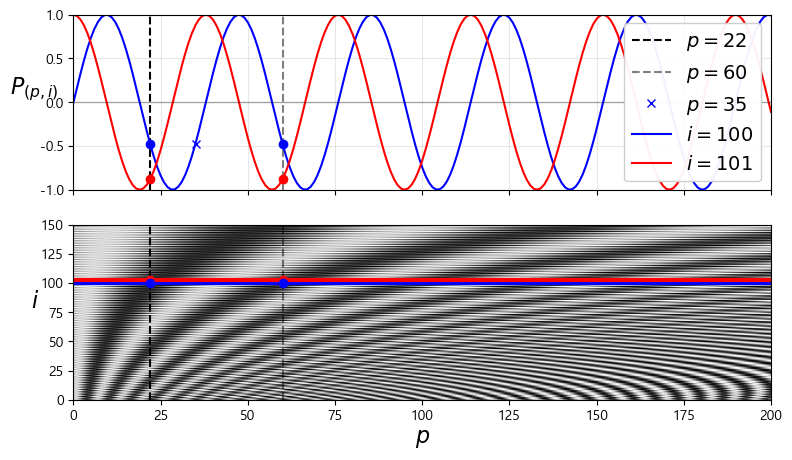

In [53]:
figure_max_length = 201
figure_embed_size = 512
pos_emb = PositionalEncoding(figure_max_length, figure_embed_size)
zeros = np.zeros((1, figure_max_length, figure_embed_size), np.float32)
P = pos_emb(zeros)[0].numpy()
i1, i2, crop_i = 100, 101, 150
p1, p2, p3 = 22, 60, 35
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(9, 5))
ax1.plot([p1, p1], [-1, 1], "k--", label="$p = {}$".format(p1))
ax1.plot([p2, p2], [-1, 1], "k--", label="$p = {}$".format(p2), alpha=0.5)
ax1.plot(p3, P[p3, i1], "bx", label="$p = {}$".format(p3))
ax1.plot(P[:,i1], "b-", label="$i = {}$".format(i1))
ax1.plot(P[:,i2], "r-", label="$i = {}$".format(i2))
ax1.plot([p1, p2], [P[p1, i1], P[p2, i1]], "bo")
ax1.plot([p1, p2], [P[p1, i2], P[p2, i2]], "ro")
ax1.legend(loc="center right", fontsize=14, framealpha=0.95)
ax1.set_ylabel("$P_{(p,i)}$", rotation=0, fontsize=16)
ax1.grid(True, alpha=0.3)
ax1.hlines(0, 0, figure_max_length - 1, color="k", linewidth=1, alpha=0.3)
ax1.axis([0, figure_max_length - 1, -1, 1])
ax2.imshow(P.T[:crop_i], cmap="gray", interpolation="bilinear", aspect="auto")
ax2.hlines(i1, 0, figure_max_length - 1, color="b", linewidth=3)
cheat = 2  # need to raise the red line a bit, or else it hides the blue one
ax2.hlines(i2+cheat, 0, figure_max_length - 1, color="r", linewidth=3)
ax2.plot([p1, p1], [0, crop_i], "k--")
ax2.plot([p2, p2], [0, crop_i], "k--", alpha=0.5)
ax2.plot([p1, p2], [i2+cheat, i2+cheat], "ro")
ax2.plot([p1, p2], [i1, i1], "bo")
ax2.axis([0, figure_max_length - 1, 0, crop_i])
ax2.set_xlabel("$p$", fontsize=16)
ax2.set_ylabel("$i$", rotation=0, fontsize=16)
plt.show()

In [ ]:
N = 2  # 원본 구조는 6
num_heads = 8
dropout_rate = 0.1
n_units = 128  # 피드 포워드 블록의 첫 번째 Dense 층의 유닛 개수
encoder_pad_mask = tf.math.not_equal(encoder_input_ids, 0)[:, tf.newaxis]
Z = encoder_in
for _ in range(N):
    skip = Z
    attn_layer = tf.keras.layers.MultiHeadAttention(
        num_heads=num_heads, key_dim=embed_size, dropout=dropout_rate)
    Z = attn_layer(Z, value=Z, attention_mask=encoder_pad_mask)
    Z = tf.keras.layers.LayerNormalization()(tf.keras.layers.Add()([Z, skip]))
    skip = Z
    Z = tf.keras.layers.Dense(n_units, activation="relu")(Z)
    Z = tf.keras.layers.Dense(embed_size)(Z)
    Z = tf.keras.layers.Dropout(dropout_rate)(Z)
    Z = tf.keras.layers.LayerNormalization()(tf.keras.layers.Add()([Z, skip]))

In [ ]:
decoder_pad_mask = tf.math.not_equal(decoder_input_ids, 0)[:, tf.newaxis]
causal_mask = tf.linalg.band_part(  # 하삼각행렬 생성
    tf.ones((batch_max_len_dec, batch_max_len_dec), tf.bool), -1, 0)

In [ ]:
encoder_outputs = Z  # 인코더의 최종 출력을 저장
Z = decoder_in  # 디코더는 자체 입력으로 시작
for _ in range(N):
    skip = Z
    attn_layer = tf.keras.layers.MultiHeadAttention(
        num_heads=num_heads, key_dim=embed_size, dropout=dropout_rate)
    Z = attn_layer(Z, value=Z, attention_mask=causal_mask & decoder_pad_mask)
    Z = tf.keras.layers.LayerNormalization()(tf.keras.layers.Add()([Z, skip]))
    skip = Z
    attn_layer = tf.keras.layers.MultiHeadAttention(
        num_heads=num_heads, key_dim=embed_size, dropout=dropout_rate)
    Z = attn_layer(Z, value=encoder_outputs, attention_mask=encoder_pad_mask)
    Z = tf.keras.layers.LayerNormalization()(tf.keras.layers.Add()([Z, skip]))
    skip = Z
    Z = tf.keras.layers.Dense(n_units, activation="relu")(Z)
    Z = tf.keras.layers.Dense(embed_size)(Z)
    Z = tf.keras.layers.LayerNormalization()(tf.keras.layers.Add()([Z, skip]))

In [ ]:
Y_proba = tf.keras.layers.Dense(vocab_size, activation="softmax")(Z)
model = tf.keras.Model(inputs=[encoder_inputs, decoder_inputs],
                       outputs=[Y_proba])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
model.fit((X_train, X_train_dec), Y_train, epochs=10,
          validation_data=((X_valid, X_valid_dec), Y_valid))

In [ ]:
translate("I like soccer and also going to the beach")

In [77]:
from transformers import pipeline

classifier = pipeline("sentiment-analysis") 
result = classifier("The actors were very convincing.")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
All PyTorch model weights were used when initializing TFDistilBertForSequenceClassification.

All the weights of TFDistilBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


In [78]:
classifier(["I am from India.", "I am from Iraq."])

[{'label': 'POSITIVE', 'score': 0.9896161556243896},
 {'label': 'NEGATIVE', 'score': 0.9811071157455444}]

In [79]:
model_name = "huggingface/distilbert-base-uncased-finetuned-mnli"
classifier_mnli = pipeline("text-classification", model=model_name)
classifier_mnli("She loves me. [SEP] She loves me not.")

All PyTorch model weights were used when initializing TFDistilBertForSequenceClassification.

All the weights of TFDistilBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


[{'label': 'contradiction', 'score': 0.9790192246437073}]

In [80]:
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = TFAutoModelForSequenceClassification.from_pretrained(model_name)

All PyTorch model weights were used when initializing TFDistilBertForSequenceClassification.

All the weights of TFDistilBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


In [81]:
token_ids = tokenizer(["I like soccer. [SEP] We all love soccer!",
                       "Joe lived for a very long time. [SEP] Joe is old."],
                      padding=True, return_tensors="tf")
token_ids

{'input_ids': <tf.Tensor: shape=(2, 15), dtype=int32, numpy=
array([[ 101, 1045, 2066, 4715, 1012,  102, 2057, 2035, 2293, 4715,  999,
         102,    0,    0,    0],
       [ 101, 3533, 2973, 2005, 1037, 2200, 2146, 2051, 1012,  102, 3533,
        2003, 2214, 1012,  102]])>, 'attention_mask': <tf.Tensor: shape=(2, 15), dtype=int32, numpy=
array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])>}

In [82]:
outputs = model(token_ids)
outputs

TFSequenceClassifierOutput(loss=None, logits=<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[-2.1123822 ,  1.1786789 ,  1.4101019 ],
       [-0.01478221,  1.0962474 , -0.9919971 ]], dtype=float32)>, hidden_states=None, attentions=None)

In [83]:
Y_probas = tf.keras.activations.softmax(outputs.logits)
Y_probas

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.016197  , 0.4352355 , 0.5485675 ],
       [0.22655998, 0.6881724 , 0.08526763]], dtype=float32)>

In [84]:
Y_pred = tf.argmax(Y_probas, axis=1)
Y_pred  # 0 = contradiction, 1 = entailment, 2 = neutral

<tf.Tensor: shape=(2,), dtype=int64, numpy=array([2, 1], dtype=int64)>

In [85]:
sentences = [("Sky is blue", "Sky is red"), ("I love her", "She loves me")]
X_train = tokenizer(sentences, padding=True, return_tensors="tf").data
y_train = tf.constant([0, 2])  # contradiction, neutral
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(loss=loss, optimizer="nadam", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=2)

Epoch 1/2
1/1 [==============================] - 11s 11s/step - loss: 0.6666 - accuracy: 0.5000
Epoch 2/2
1/1 [==============================] - 0s 80ms/step - loss: 0.3184 - accuracy: 1.0000
